# Clean the air and the soil

As suggested by the histograms and visualizations, the density of the actual plant lies somewhere between the density of air and soil. Part of the soil and the pot material also lies in the same range, so a quick thresholding might not work. The strategy here has four steps:

- Standardize the density values
    - Make sure the air and soil have the same density before any other step.
    

- Remove most of the slices, since these just contain air
    - This will significantly reduce the size of the scan, making further processing much quicker.
    

- Remove most of the air by blurring the image with a Gaussian
    - Threshold out the air according to the blurred values
    
    
- Remove most of the soil by eroding out the arabidopsis by masking it out
     - The plant material is quite thin, so a few erosions should erase it from the scan.
     - The remainder should be the thicker chunks of material _aka_ soil
     - We can then mask the soil from the plant scan.

**The following strategy was devised with preliminary data at hand**. It is expected that in future scans, the soil removal will be simply a matter of deleting all the slices below certain height level.

In [1]:
import os

import scipy.ndimage as ndimage
from importlib import reload

import tifffile as tf
import numpy as np
import pandas as pd

import arabidopsis_utils as thales

In [2]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [3]:
tiff_file = '../raw3d/u112-3.tif'
pot_dst = '../pots/'
norm_src = '../normalization/vals/'

src, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]
img = tf.imread(tiff_file)

In [4]:
dst = pot_dst + bname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
print('All results will be saved in ', dst)

All results will be saved in  ../pots/u112-3/


## Standardize the density values

- As detailed in the previous two notebooks, it will be very convenient to have the same density values for air and soil across all the raw scans.

- In the previous notebook, we computed the coeficients for a linear adjustment: Now we just need to apply it to the scan itself.

Load the coefficients $a,b,c$ of the polynomial adjustment as computed before. 

For each voxel with density value $\rho\in\{0,1,\ldots,255\}$, we compute $f(\rho)=a\rho+b$.

We then normalize the density values as
$$ g(\rho) = \begin{cases}
255, &\text{if }\; f(\rho) > 255,\\
f(\rho), &\text{if }\; 0\leq f(\rho)\leq 255,\\
0, &\text{if }\; f(\rho)<0.
\end{cases} $$

In [5]:
adjust_by = np.loadtxt(norm_src + bname+'_coefs.csv', dtype='float', delimiter=',')
print('Polynomials coefficients,\t', adjust_by)

if bname != 'col-0':
    img = thales.normalize_density(img, adjust_by)

Polynomials coefficients,	 [2.93012599 0.96634073]


## Remove slices that are purely air or mostly soil

- Across the height slices, compute the max and min intensity value.
- If the difference between them is small, then that slice has just air and can be safely discarded
- We assume that the pot+plant is at least 200 slices tall.


- On the other hand, if a slice contains a very high density voxel, most like this voxel is soil and is surrounded by more soil.
- All the slices below it must be soil, and can be safely removed.
- We assume that there are at least 10 slices between the pure air and the soil.


- Averages and variances are not really informative, as a small cluster of plant material will be drowned amid a sea of air.


- Resize the scan according.
- **By reducing the size of the scan, further processing can be done quicker.**

In [6]:
avgs = np.mean(img, axis=(1,2))
maxs = np.max(img, axis=(1,2))
mins = np.min(img, axis=(1,2))
diff = maxs - mins

min_height = 200
upcutoff = np.nonzero(diff[min_height:] < 6)[0][0] + min_height
dwcutoff = np.nonzero(diff == np.max(diff))[0][-1]
if dwcutoff > upcutoff - 10:
    dwcutoff = 0

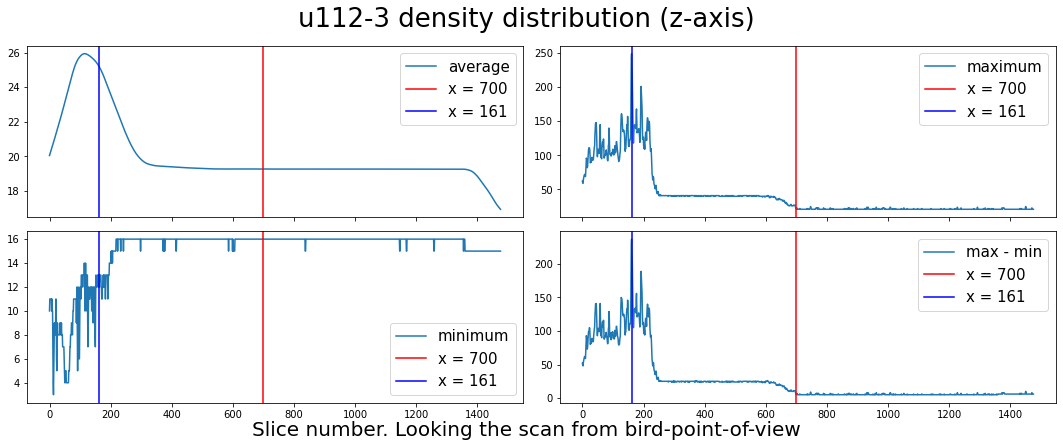

In [26]:
fig, ax = plt.subplots(2,2, figsize=(15,6), sharex=True)
xrange = np.arange(len(avgs), dtype=np.uint16)
ax[0,0].plot(xrange, avgs, label = 'average');
ax[0,1].plot(xrange, maxs, label = 'maximum');
ax[1,0].plot(xrange, mins, label = 'minimum');
ax[1,1].plot(xrange, diff, label = 'max - min');

fig.suptitle(bname + ' density distribution (z-axis)', fontsize=26)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].axvline(x=upcutoff, c='r', label='x = {}'.format(upcutoff))
        ax[i,j].axvline(x=dwcutoff, c='b', label='x = {}'.format(dwcutoff))
        ax[i,j].legend(fontsize=15)
        
        
fig.text(0.5,0.0, "Slice number. Looking the scan from bird-point-of-view", ha="center", va="center", fontsize=20)
fig.tight_layout()

In [9]:
img = img[dwcutoff:upcutoff, : ,:]

## Remove air: Gaussian blurring and thresholding

- A low density voxel can be air outside, or it could be some air/low density material inside the plant.

- To determine better the situation, we will first blur the image.

- A low density voxel _inside_ the plant will likely be surrounded by higher density voxels.
    - Thus its blurred value would be high
    
- On the other hand, a low density voxel _outside_ the plant will be surrounded by low density voxels and its blurred value would be low.


- Threshold out the voxels whose blurred value is low.

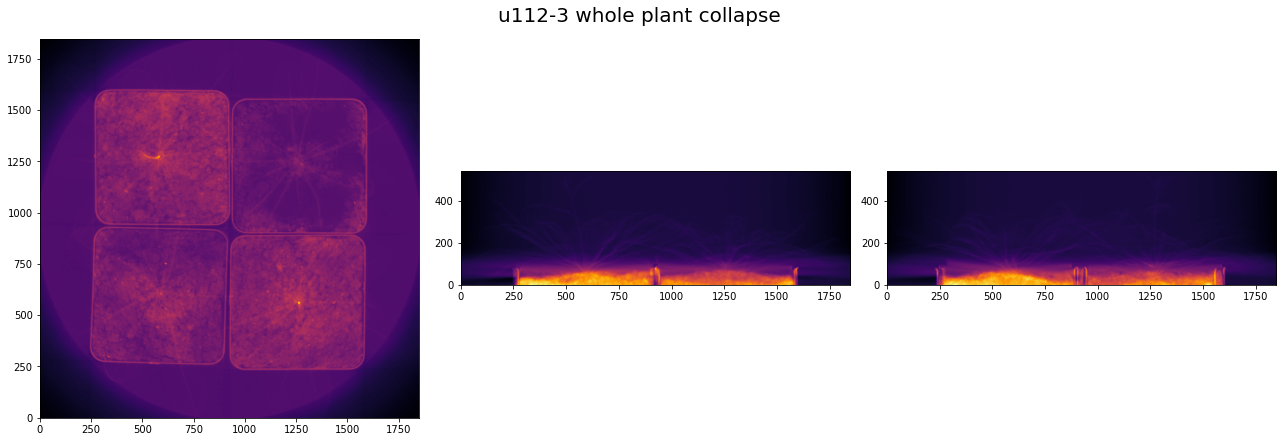

In [10]:
snaps = thales.collapse_dimensions(img)
thales.plot_collapse_dimensions(snaps, bname, 'whole plant')

[(inf, None, 19), (2300105, 28, 33), (6962, 42, 43), (2140, 71, 72), (376, 99, 100), (33, 106, 107), (32, 128, 129), (22, 139, 140), (22, 82, 83), (21, 124, 125), (18, 117, 119), (13, 136, 138), (10, 143, 151), (8, 131, 133), (7, 146, 145), (5, 155, 158), (5, 150, 149), (4, 171, 170), (4, 169, 182), (3, 189, 187), (3, 183, 191), (3, 177, 174), (3, 165, 167), (3, 148, 147), (2, 220, 219), (2, 216, 215), (2, 214, 213), (2, 206, 205), (2, 201, 200), (2, 195, 193), (2, 192, 227), (2, 185, 184), (2, 181, 180), (2, 122, 123), (1, 228, 248), (1, 226, 225), (1, 222, 221), (1, 212, 211), (1, 210, 209), (1, 204, 203), (1, 198, 197), (1, 160, 163), (1, 157, 156), (1, 120, 121), (0, 249, 254), (0, 102, 103)]
25


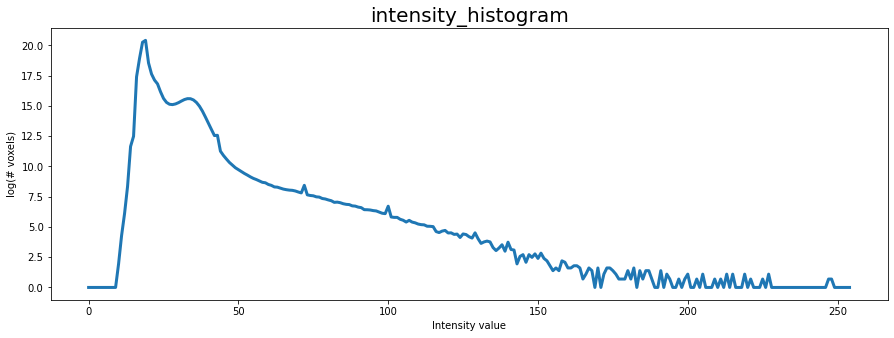

In [11]:
thr = thales.get_individual_threshold(img, True)
print(thr)

In [12]:
sigma = 3
avg = ndimage.gaussian_filter(img, sigma=sigma, mode='mirror', truncate=3, cval=0)

[(inf, None, 17), (2047143, 24, 30), (11, 81, 82), (11, 77, 78), (0, 89, 254), (0, 86, 87), (0, 68, 69)]
26


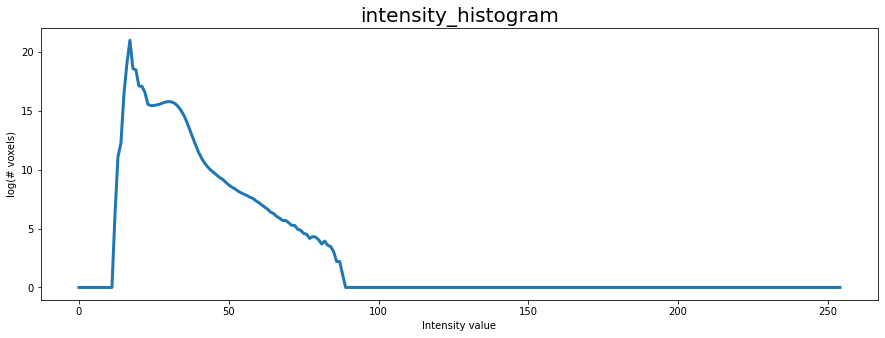

In [13]:
thr = thales.get_individual_threshold(avg, True)
print(thr)

In [18]:
thr = 40
timg = img.copy()
timg[avg < 21] = 0
#timg[avg > 35] = 0

2 2


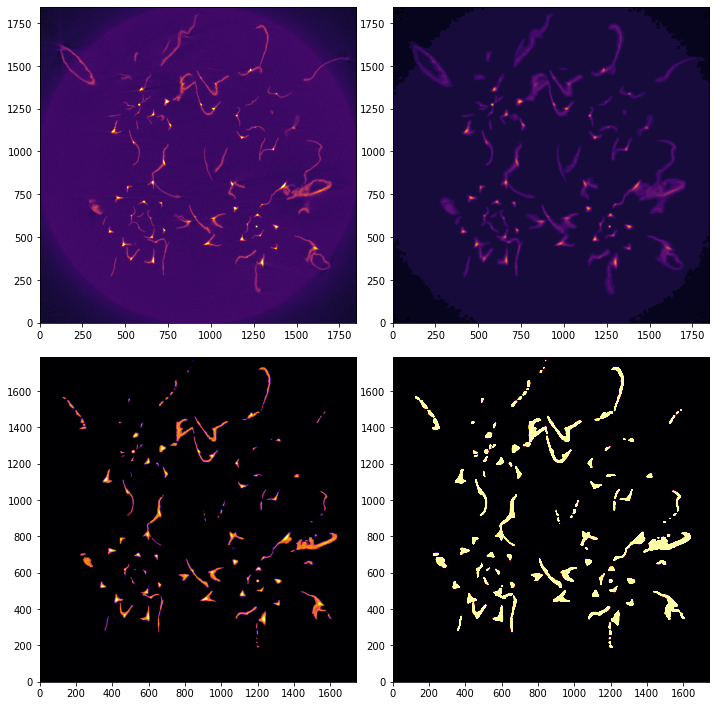

In [31]:
k = 155
ss = np.s_[k,:,:]

thales.plot4x4panel([img, avg, timg, timg], ss, vmax=[35,35,35,1])

In [27]:
timg.shape

(537, 1790, 1742)

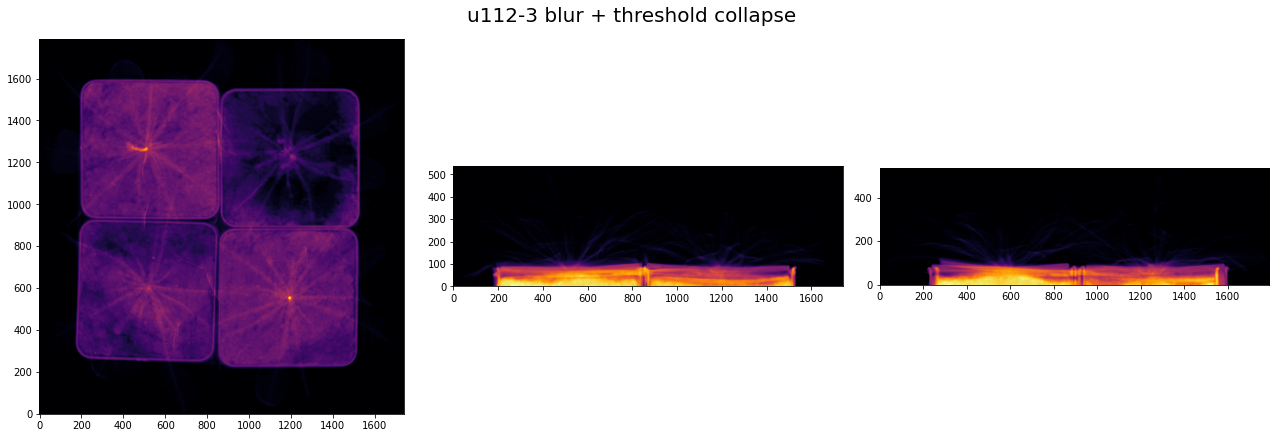

In [23]:
snaps = thales.collapse_dimensions(timg)
thales.plot_collapse_dimensions(snaps, bname, 'blur + threshold')

In [22]:
timg, _, _ = thales.clean_zeroes(timg)

9 % reduction from input


## Remove soil: Aggressive opening

Most likely only soil will remain.

- Treat the end result as a mask for the soil.
- Use it to remove the soil from the original.

In [32]:
binimg = timg.copy()
binimg[binimg > 0] = 1

In [33]:
strucx = ndimage.generate_binary_structure(img.ndim, 1)
strucx[1,:,:] = True
strucx

array([[[False, False, False],
        [False,  True, False],
        [False, False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False, False, False],
        [False,  True, False],
        [False, False, False]]])

In [34]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
erode = ndimage.binary_erosion(binimg, structure=strucx, iterations = 12)

In [35]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
dilate = ndimage.binary_dilation(erode, structure=strucx, iterations = 12)

In [36]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
erode2 = ndimage.binary_erosion(dilate, structure=strucx, iterations = 12)

In [37]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
dilate2 = ndimage.binary_dilation(erode2, structure=strucx, iterations = 15)

In [40]:
soilless = timg*~dilate

2 2


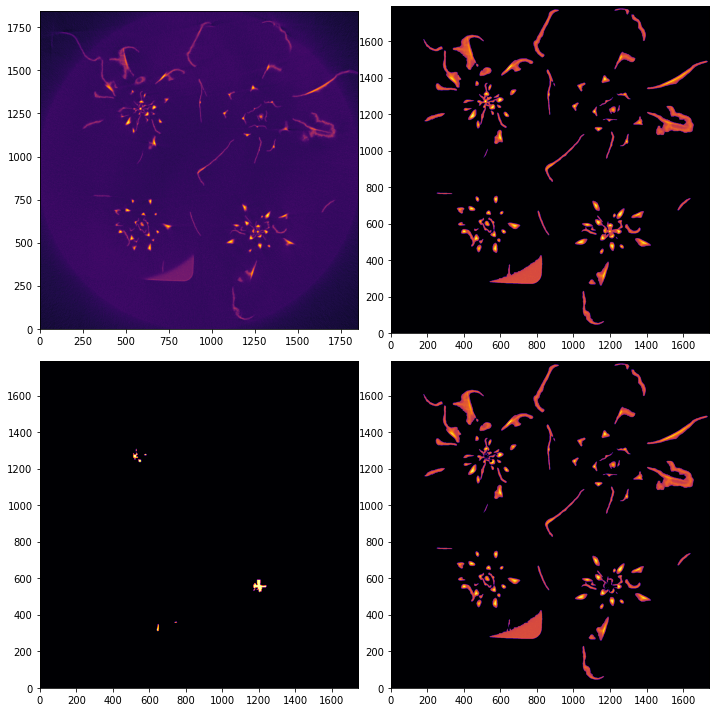

In [55]:
k = 115
ss = np.s_[k,:,:]

thales.plot4x4panel([img, timg, dilate, soilless], ss)#, vmax=[150,150,150,150])

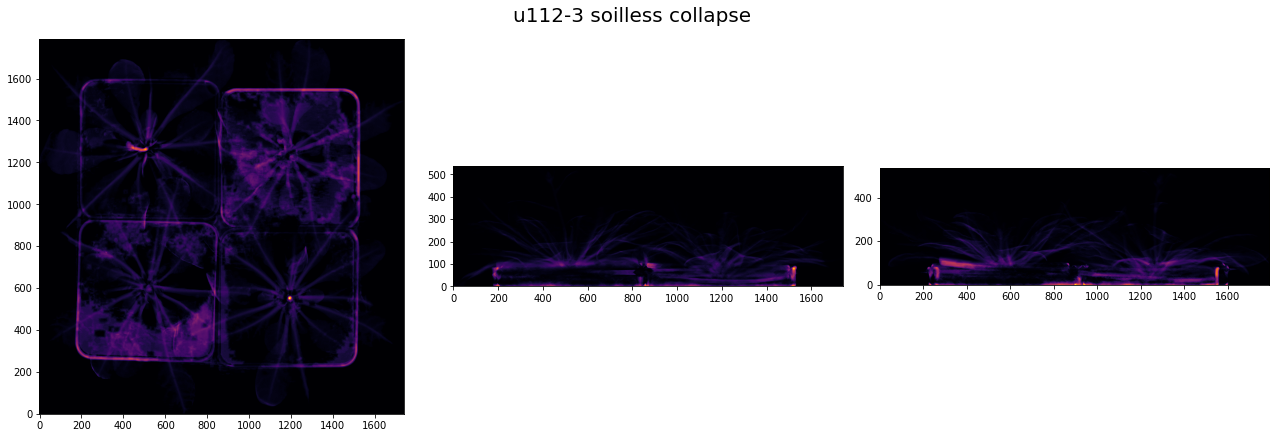

In [49]:
snaps = thales.collapse_dimensions(soilless)
thales.plot_collapse_dimensions(snaps, bname, 'soilless')

[(inf, None, 21), (586, 42, 43), (82, 71, 72), (23, 99, 100), (16, 62, 63), (13, 74, 75), (10, 112, 114), (10, 90, 92), (6, 83, 84), (5, 116, 121), (5, 97, 98), (4, 94, 96), (3, 126, 129), (3, 110, 111), (2, 128, 127), (2, 122, 124), (2, 119, 118), (2, 85, 86), (2, 77, 78), (2, 68, 69), (2, 66, 67), (1, 136, 135), (1, 132, 141), (1, 106, 108), (1, 104, 105), (1, 102, 103), (1, 81, 82), (0, 142, 254), (0, 87, 88)]
31


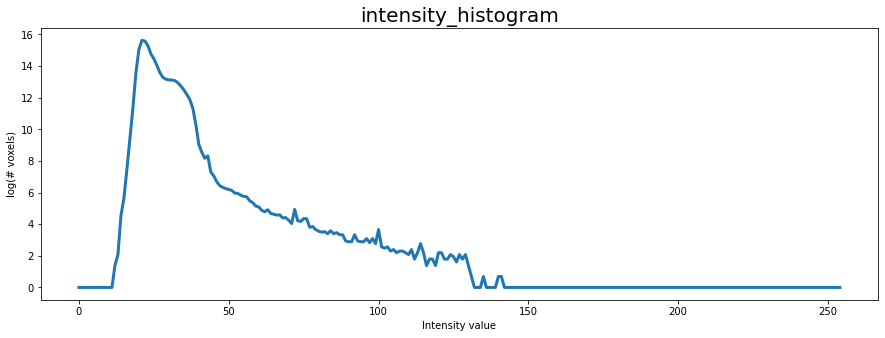

In [51]:
thr = thales.get_individual_threshold(soilless, True)
print(thr)

In [52]:
tf.imwrite(dst + 'airless.tif', timg, photometric='minisblack',compress=3)
tf.imwrite(dst + 'soilless.tif', soilless, photometric='minisblack', compress=3)